In [1]:
from __future__ import division 
import pymc3 as pm ;import matplotlib.pyplot as plt
import seaborn as sns ; from theano import tensor as tt
import numpy as np ; import scipy as sp ; import pandas as pd; import os 
import theano as T; from scipy.stats import gamma
plt.style.use("classic")

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from numpy import pi, log
def FechKal(ar39, time):
    da2 = []
    # Start by calculating the fractional release
    t = np.cumsum(ar39)
    t_c = np.cumsum(time)
    diff_t = t_c[1:-1] - t_c[0:-2]
    f = t/t[-1]
    da2_a = np.zeros([len(ar39)])
    da2_a[0] = ((f[0]**2 - 0**2))*pi/(36*(t_c[0]))
    
    # All other steps for equation 1 
    da2_a[1:-1] = ((f[1:-1]**2 - (f[0:-2])**2)*pi/(36*(diff_t)))
    
    # Equation 2
    da2_b = np.zeros([len(ar39)])
    dif_f = f[1:-1] - f[0:-2]
    da2_b[1:-1] = (1/((pi**2)*diff_t))*(-(pi*pi/3)*dif_f -
                                             (2*pi)*(np.sqrt(1 -(pi/3)*f[1:-1]) - np.sqrt(1 - (pi/3)*f[0:-2])))
    
    # Equation 3
    da2_c = np.zeros([len(ar39)])
    da2_c[1:-1] = (1/(pi*pi*diff_t)*log((1-f[0:-2])/(1 - f[1:-1])))
    
    # Need to decide which to use 
    # > 0 and <= 0.1 - a
    # > 0.1 and <= 0.9 - b
    # >0.9 and <=1 - c
    a = da2_a[(da2_a <= 0.1) & (da2_a >0)]
    b = da2_b[(da2_b > 0.1) & (da2_b <= 0.9)]
    c = da2_c[(da2_c > 0.9) & (da2_c <= 1)]
    
    # put all the values into an array 
    
    da2.extend(a)
    da2.extend(b)
    da2.extend(c)
    
    return da2

In [3]:
# Cassata Fish Canyon Sanidine 
''' 
Cassata Thesis Fish Canyon Sanidine 
Ideal Single Domain Behaviour 
Model Test
'''
cwd = os.getcwd()
os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df = pd.read_csv("Cassata_FCs2.csv", engine = 'python')
z = df.as_matrix(columns= None)
z = np.transpose(z)
time = np.transpose(z[1,:]) 
temp = np.transpose(z[0,:])
ar39 = np.transpose(z[2,:])
xx = temp

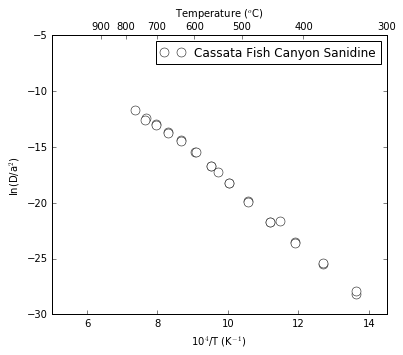

In [4]:
# Cassata Fish Canyon Sanidine

r = FechKal(ar39, time)
r = np.log(r) 
tplot = 1e4/(temp + 273.15)
fig, ax = plt.subplots(figsize = (6,5))

ax.plot(tplot[1:29], r[1:29], 'o', markersize = 9, 
         color = 'w', alpha = 1,
        label = 'Cassata Fish Canyon Sanidine', 
       markeredgecolor = 'k');
ax.set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax.set_ylabel('ln(D/a$^{2}$)')
ax.set_xlim(5, 14.5)
ax.set_ylim(-30, -5)
plt.legend()

ax2 = ax.twiny()
Tdc = np.array([300, 400, 500, 600, 700, 800, 900]);
Tp = 10e3/(Tdc + 273.15);
labels = list(['300', '400', '500','600', '700', '800', '900', '1000', '1100'])
ax2.plot(tplot[1:29], r[1:29], 'o', markersize = 9, 
         color = 'grey', alpha = 0);
ax.set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp);
ax2.set_xticklabels(labels);

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


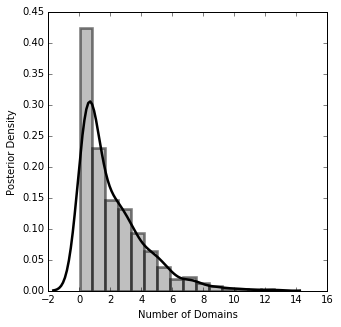

In [5]:
# The number of domians prior
'''
We want to sample more predominantly 
from the lower number of domains (e.g., 1 - 5)
however we do not want to limit the sampling space 
We therefore choose the gamma distribution as the 
prior for the number of domains
'''

g = np.random.gamma(1,2, 500);
plt.figure(figsize = (5,5))
sns.distplot(g,bins = 15, hist_kws = {"lw":2.6, "edgecolor":'k', "alpha" : 0.5,
                           "color":'grey'},
             kde_kws = {"lw":2.5, "color": 'k', "ls":"-"});
plt.xlabel('Number of Domains'); plt.ylabel('Posterior Density');

# Cassata Fish Canyon
Simple Ideal Single Domian Arrhenian Behaviour

In [6]:
# Simple Model!
# How many domains? 
data = r[1:29][:, np.newaxis]
k = 42
N = data.shape[0]
tempk = temp + 273.15
x = tempk[1:29][:, np.newaxis] 
R = 8.314e-3

In [7]:
def stick_breaking(beta): 
    portion_remaining = tt.concatenate([[1],
                                        tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [129]:
k = 22
with pm.Model() as DMM: 
    # Domain Characteristics
    alpha = pm.Gamma('alpha', 1., 2.)
    beta = pm.Beta('beta', 1., alpha, shape = k)
    phi = pm.Deterministic('phi', stick_breaking(beta))
    phi = phi/phi.sum()
    domain = pm.Categorical('domain', p = phi, shape = N)
    phi_sort = pm.Deterministic('phi_sort', tt.sort(phi))
    rho = pm.Bound(pm.Normal, lower = 0.0, upper = 0.025)('rho', mu = 0, sd = 0.025/2, shape = k)

    
    # Diffusion Kinetics
    ea = pm.Normal('Ea', 0, 300, shape = k, testval = 150)
    d0 = pm.Normal('D0', 5, 1, shape = k, testval = 4)
    
    # Sorting the Variables 
    ea_dom = pm.Deterministic('ea_dom', ea[domain])
    d0_dom = pm.Deterministic('d0_dom', d0[domain])
    rho_dom = pm.Deterministic('rho_dom', rho[domain])
    phi_dom = pm.Deterministic('phi_dom', phi[domain])
    
    # R from equation
    R_dom = pm.Deterministic('R_dom', (tt.sum(phi_dom/rho_dom)**-1))
    
    # Error 
    err = pm.HalfNormal('err', sd = 10)
    
    # Model - Expected values 
    mu = tt.log(d0_dom/(R_dom**2)) - ea_dom/(R*x)
    
    # Likelihood 
    obs = pm.Normal('obs', mu = mu, sd = err, 
                   observed = data)

In [143]:
with DMM: 
    step1 = pm.Metropolis(vars=[alpha, beta, phi, rho, ea, d0, err])
    step2 = pm.ElemwiseCategorical([domain], np.arange(k))
    trace = pm.sample(1000000, tune = 50000, step = [step1, step2],
                     cores = 3)
        
   

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [err]
>>Metropolis: [D0]
>>Metropolis: [Ea]
>>Metropolis: [rho]
>>Metropolis: [beta]
>>Metropolis: [alpha]
>ElemwiseCategorical: [domain]
Sampling 3 chains: 100%|██████████| 3150000/3150000 [1:58:49<00:00, 441.85draws/s]  
/Applications/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Applications/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conver

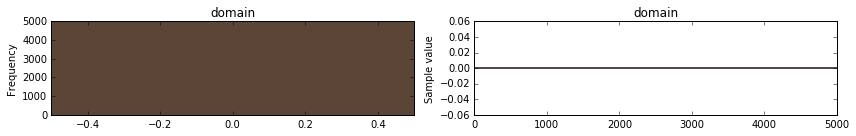

In [166]:
pm.traceplot(trace[-5000:], varnames =['domain']); 

In [167]:
n_domains = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['domain'])

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


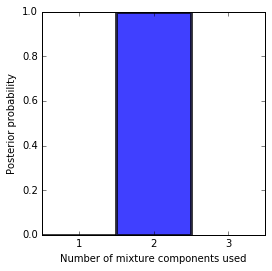

In [168]:
n_domains = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['domain'])
fig, ax = plt.subplots(figsize=(4, 4))

bins = np.arange(n_domains.min(), n_domains.max() + 1)
ax.hist(n_domains + 1, bins=bins, normed=True, lw=3, alpha=0.75);

ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of Domains');

ax.set_ylabel('Posterior probability');

In [169]:
with DMM: 
    ppc = pm.sample_ppc(trace, 1000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 1000/1000 [00:03<00:00, 261.32it/s]


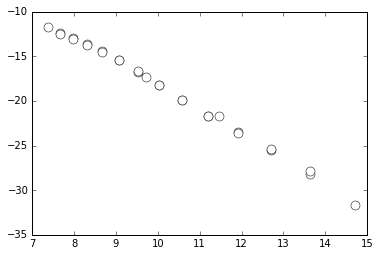

In [170]:
plt.plot(tplot[1:29], r[1:29], 'o', markersize = 9, 
         color = 'w', alpha = 1,
        label = 'Cassata Fish Canyon Sanidine', 
       markeredgecolor = 'k');
plt.plot(tplot[1:29], ppc['obs'].mean(axis = 0), 'o', color = 'grey'); 

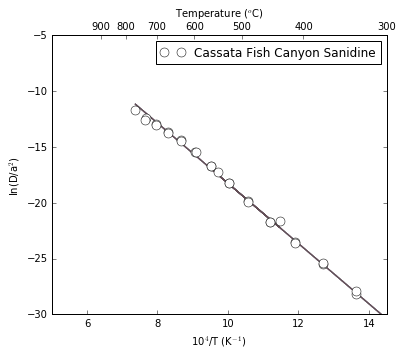

In [161]:
trx = trace[-1:]

fig, ax = plt.subplots(figsize = (6,5))
for a, b, c in zip(trx['ea_dom'], trx['d0_dom'], trx['R_dom']):
    mu = np.log(b/(c**2)) - a/(R*x)
    ax.plot(tplot[1:29], mu, alpha = 0.1, lw = 1.2)

ax.plot(tplot[1:29], r[1:29], 'o', markersize = 9, 
         color = 'w', alpha = 1,
        label = 'Cassata Fish Canyon Sanidine', 
       markeredgecolor = 'k');
ax.set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax.set_ylabel('ln(D/a$^{2}$)')
ax.set_xlim(5, 14.5)
ax.set_ylim(-30, -5)
plt.legend()

ax2 = ax.twiny()
Tdc = np.array([300, 400, 500, 600, 700, 800, 900]);
Tp = 10e3/(Tdc + 273.15);
labels = list(['300', '400', '500','600', '700', '800', '900', '1000', '1100'])
ax2.plot(tplot[1:29], r[1:29], 'o', markersize = 9, 
         color = 'grey', alpha = 0);
ax.set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp);
ax2.set_xticklabels(labels);

In [171]:
# Tremblay Data - Don't Expect to work 

In [8]:
# Tremblay Quartz 04-RDY-139-STR
'''
Comparison with Frequentist Misfit statistical Method 
Model Test against known 
2-Domain model 
d1 = 0.75, d2 = 0.25
'''
cwd = os.getcwd()
os.chdir("/Users/jackcarter/Documents/Data_Mixtures")
df2 = pd.read_csv("Tremblay_Quartz.csv", engine = 'python')
q = df2.as_matrix(columns = None)
q = np.transpose(q)
time2 = np.transpose(q[1,:])
temp2 = np.transpose(q[0,:])
he = np.transpose(q[2,:])
time2 = time2 * 60 * 60

No handles with labels found to put in legend.


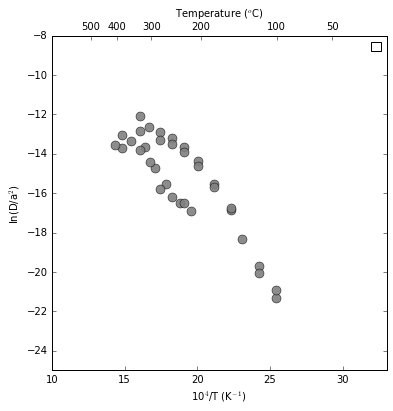

In [30]:
# Tremblay Quartz

'''
Two Domain Model 
'''

r2 = FechKal(he, time2)
r2 = np.log(r2) 
tplot2 = 1e4/(temp2 + 273.15)
fig, ax = plt.subplots(figsize = (6,6))
ax.plot(tplot2[:35], r2[:35], 'o', markersize = 9, 
         color = 'grey', alpha = 0.9, label = 'Tremblay Quartz');
ax.set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax.set_ylabel('ln(D/a$^{2}$)')
ax.set_xlim(10, 33)
ax.set_ylim(-25, -8)

ax2 = ax.twiny()
Tdc = np.array([50, 100, 200, 300, 400, 500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['50', '100', '200', '300', '400', '500'])
ax2.plot(tplot2[:35], r2[:35], alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)
plt.legend()

In [31]:
idx = np.linspace(0, len(data)-1, len(data))
idx = idx.astype(int)

In [32]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [53]:
k = 10
R = 8.314e-3
data = r2[:35]
N = data.shape[0]
x = temp2[:, None][:35]+ 273.15
data =r2[:35]
with pm.Model() as DMM: 
    # Domain Characteristics
    alpha = pm.Gamma('alpha', 1., 2., testval = 3)
    beta = pm.Beta('beta', 1., alpha, shape = k)
    phi = pm.Deterministic('phi', stick_breaking(beta))
    bounding_penalty2 = pm.Potential('p_min_potential2', tt.switch(phi < 1e-6, -np.inf, 0))
    phi = phi/phi.sum()
    domain = pm.Categorical('domain', p = phi, shape = N, testval = 6)
    phi_sort = pm.Deterministic('phi_sort', tt.sort(phi))
    rho = pm.Bound(pm.Normal, lower = 0.0)('rho', mu = 0, sd = 0.1, shape = k, testval = 0.5)

    
    # Diffusion Kinetics
    ea = pm.Bound(pm.Normal, lower = 90)('Ea', mu = 120, sd = 100, shape = k, testval = 180)
    d0 = pm.Normal('D0', 0, 100**2, shape = k, testval = 5)
    
    # Sorting the Variables 
    ea_dom = pm.Deterministic('ea_dom', ea[domain])
    d0_dom = pm.Deterministic('d0_dom', d0[domain])
    rho_dom = pm.Deterministic('rho_dom', rho[domain])
    phi_dom = pm.Deterministic('phi_dom', phi[domain])
    
    # R from equation
    R_dom = pm.Deterministic('R_dom', (tt.sum(phi_dom/rho_dom)**-1))
    
    # Error 
    err = pm.HalfNormal('err', sd = 10)
    
    # Model - Expected values 
    mu = tt.log(d0_dom/(R_dom**2)) - ea_dom/(R*x[idx])
    
    # Likelihood 
    obs = pm.Normal('obs', mu = mu, sd = err, 
                   observed = data)

In [ ]:
with DMM:
    #step1 = pm.NUTS(vars=[ phi, rho, ea, d0,
    #                      err,alpha,beta])
    #step3 = pm.Metropolis([err,alpha,beta])
    #step2 = pm.ElemwiseCategorical([domain], np.arange(k))
    #trace = pm.sample(50000, tune = 10000,# step = [step1, step2],
    #                 cores = 2, nuts_kwargs=dict(target_accept=.95))
    trace = pm.sample(20000, tune =20000, 
                     cores = 3) 
                     #step = [step1, step2], 
                    # kwargs = dict(target_accept = 0.95))

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>NUTS: [err, D0, Ea, rho, beta, alpha]
>CategoricalGibbsMetropolis: [domain]
Sampling 3 chains:  35%|███▍      | 41723/120000 [09:41<15:43, 82.95draws/s]  

In [ ]:
pm.traceplot(trace[-1000:], 
            varnames = ['domain', 'phi', 'rho', 
                       'ea_dom', 'd0_dom']); 

In [ ]:
trx = trace[-100:]

fig, ax = plt.subplots(figsize = (6,5))
for a, b, c in zip(trx['ea_dom'], trx['d0_dom'], trx['R_dom']):
    mu = np.log(b/(c**2)) - a/(R*x)
    ax.plot(tplot2[:35], mu, alpha = 0.01, lw = 1.2)
    
ax.plot(tplot2[:35], r2[:35], 'o', markersize = 9, 
         color = 'grey', alpha = 0.9, label = 'Tremblay Quartz');
ax.set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax.set_ylabel('ln(D/a$^{2}$)')
ax.set_xlim(10, 33)
ax.set_ylim(-25, -8)

ax2 = ax.twiny()
Tdc = np.array([50, 100, 200, 300, 400, 500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['50', '100', '200', '300', '400', '500'])
ax2.plot(tplot2[:35], r2[:35], alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)
plt.legend()

In [ ]:
with DMM:
    ppc = pm.sample_ppc(trace[-1000:], 100)

In [ ]:
r2 = FechKal(he, time2)
r2 = np.log(r2) 
tplot2 = 1e4/(temp2 + 273.15)
fig, ax = plt.subplots(figsize = (6,6))
ax.plot(tplot2[:35], r2[:35], 'o', markersize = 9, 
         color = 'grey', alpha = 0.9, label = 'Tremblay Quartz');
ax.set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax.set_ylabel('ln(D/a$^{2}$)')
ax.set_xlim(10, 33)
ax.set_ylim(-25, -8)

ax2 = ax.twiny()
Tdc = np.array([50, 100, 200, 300, 400, 500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['50', '100', '200', '300', '400', '500'])
ax2.plot(tplot2[:35], r2[:35], alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)
plt.legend()

plt.plot(tplot2[:len(ppc['obs'].mean(axis =0))], ppc['obs'].mean(axis =0), 'o');

In [ ]:
n_domains = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['domain'])
fig, ax = plt.subplots(figsize=(4, 4))

bins = np.arange(n_domains.min(), n_domains.max() + 1)
ax.hist(n_domains + 1, bins=bins, normed=True, lw=3, alpha=0.75);

ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of Domains');

ax.set_ylabel('Posterior probability');